<a href="https://colab.research.google.com/github/PrathamSetia/Enhancing-Medical-Image-Segmentation-with-GANs-Transfer-Learning-and-Data-Augmentation/blob/main/liver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation_models_pytorch nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import nibabel as nib # The standard library for Medical 3D files
import matplotlib.pyplot as plt

# 1. Install Dependencies
try:
    import nibabel
except ImportError:
    print("Installing nibabel...")
    os.system('pip install nibabel')
    import nibabel as nib

# 2. Define the Dummy Generator
def create_synthetic_liver_ct(filename_vol, filename_mask):
    print(f"Generating synthetic 3D CT volume: {filename_vol}...")

    # Create a 3D block: 64 slices, each 128x128 pixels
    # In real life, this would be ~512x512 with 100-500 slices
    depth, height, width = 64, 128, 128

    # Background: -1000 HU (Air)
    volume = np.full((depth, height, width), -1000, dtype=np.float32)
    mask = np.zeros((depth, height, width), dtype=np.uint8)

    # Create a "Body" cylinder (0 HU - Water/Tissue)
    cy, cx = height // 2, width // 2
    y, x = np.ogrid[:height, :width]
    mask_body = (x - cx)**2 + (y - cy)**2 <= 50**2
    for z in range(depth):
        volume[z][mask_body] = 0

    # Create a "Liver" blob (Bright tissue: 60 HU)
    # Located in slices 20-40
    for z in range(20, 45):
        # Shifted slightly right
        mask_liver = (x - (cx+10))**2 + (y - (cy+10))**2 <= 15**2
        volume[z][mask_liver] = 60 # Normal Liver Density
        mask[z][mask_liver] = 1    # Class 1: Liver

        # Create a "Tumor" inside the liver (Dark spot: 20 HU)
        if 25 < z < 35:
            mask_tumor = (x - (cx+10))**2 + (y - (cy+10))**2 <= 5**2
            volume[z][mask_tumor] = 20 # Tumor is often darker in CT
            mask[z][mask_tumor] = 2    # Class 2: Tumor

    # Add Gaussian Noise to make it look like a real noisy CT
    noise = np.random.normal(0, 10, volume.shape)
    volume += noise

    # 3. Save as NIfTI (.nii.gz)
    # We need an affine matrix (mapping pixel coordinates to real-world mm)
    # We use identity for simulation
    affine = np.eye(4)

    nii_vol = nib.Nifti1Image(volume, affine)
    nii_mask = nib.Nifti1Image(mask, affine)

    nib.save(nii_vol, filename_vol)
    nib.save(nii_mask, filename_mask)
    print("✅ Synthetic CT Scan Created!")

# 3. Execute
os.makedirs('/content/liver_data', exist_ok=True)
create_synthetic_liver_ct(
    '/content/liver_data/volume-0.nii.gz',
    '/content/liver_data/segmentation-0.nii.gz'
)

Generating synthetic 3D CT volume: /content/liver_data/volume-0.nii.gz...
✅ Synthetic CT Scan Created!


In [ ]:
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class LiverCTDataset(Dataset):
    def __init__(self, volume_path, mask_path, transform=None):
        self.volume_path = volume_path
        self.mask_path = mask_path
        self.transform = transform

        print(f"Loading 3D Volume: {volume_path}")
        # Load data into memory
        self.volume = nib.load(volume_path).get_fdata()
        self.mask = nib.load(mask_path).get_fdata()

        # Pre-Calculate valid slices (only those containing liver/tumor)
        self.valid_slices = []
        for i in range(self.mask.shape[0]):
            if np.sum(self.mask[i]) > 0:
                self.valid_slices.append(i)

        print(f"Found {len(self.valid_slices)} slices containing liver.")

    def __len__(self):
        return len(self.valid_slices)

    def window_image(self, img, min_hu=-100, max_hu=200):
        """Clips CT Hounsfield Units to Liver Window"""
        img = np.clip(img, min_hu, max_hu)
        img = (img - min_hu) / (max_hu - min_hu)
        return (img * 255).astype(np.uint8)

    def __getitem__(self, idx):
        slice_idx = self.valid_slices[idx]

        # 1. Extract 2D Slice
        img_slice = self.volume[slice_idx, :, :]
        mask_slice = self.mask[slice_idx, :, :]

        # 2. Windowing
        img_windowed = self.window_image(img_slice)
        img_rgb = cv2.cvtColor(img_windowed, cv2.COLOR_GRAY2RGB)

        # 3. Augmentation OR Manual Tensor Conversion
        if self.transform:
            augmented = self.transform(image=img_rgb, mask=mask_slice)
            img_rgb = augmented['image']
            mask_slice = augmented['mask']
        else:
            # --- THE FIX IS HERE ---
            # If no transform is used (e.g. visualization), manually convert to Tensor

            # Image: Numpy [H, W, 3] -> Tensor [3, H, W]
            img_rgb = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

            # Mask: Numpy -> Tensor
            mask_slice = torch.from_numpy(mask_slice).long()

        # 4. Prepare Mask (Binary: Liver+Tumor vs Background)
        # Convert to Float Tensor for the model
        mask_slice = (mask_slice > 0).float()

        # Add channel dimension if it's missing [H, W] -> [1, H, W]
        if mask_slice.ndim == 2:
            mask_slice = mask_slice.unsqueeze(0)

        return img_rgb, mask_slice

# Define standard transform
liver_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

Loading 3D Volume: /content/liver_data/volume-0.nii.gz
Found 25 slices containing liver.


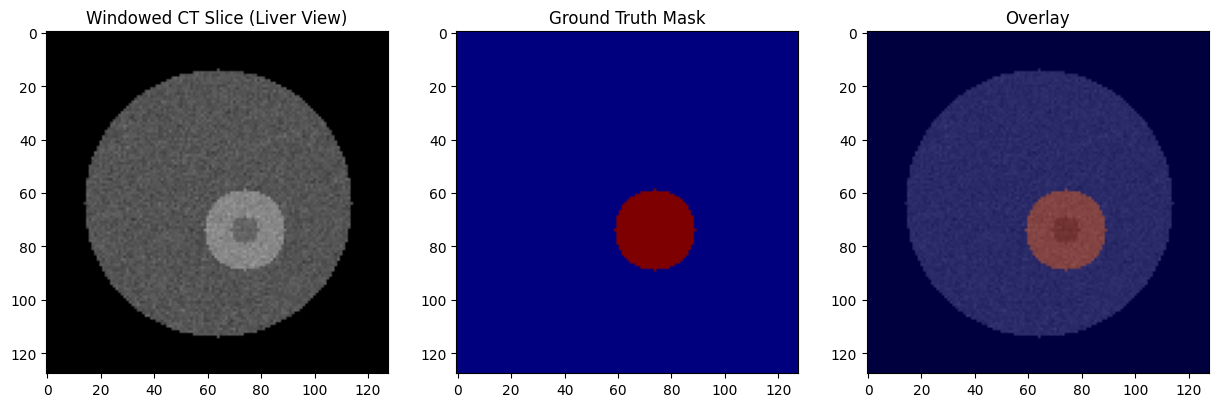

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize Dataset
dataset = LiverCTDataset(
    volume_path='/content/liver_data/volume-0.nii.gz',
    mask_path='/content/liver_data/segmentation-0.nii.gz',
    transform=None
)

# Visualize slices
if len(dataset) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Pick a middle slice
    idx = len(dataset) // 2
    img_tensor, mask_tensor = dataset[idx]

    # Convert Tensors back to Numpy for display
    # Image: [3, H, W] -> [H, W, 3]
    img = img_tensor.permute(1, 2, 0).numpy()
    # Mask: [1, H, W] -> [H, W]
    mask = mask_tensor[0].numpy()

    # 1. Image
    axes[0].imshow(img)
    axes[0].set_title("Windowed CT Slice (Liver View)")

    # 2. Mask
    axes[1].imshow(mask, cmap='jet')
    axes[1].set_title("Ground Truth Mask")

    # 3. Overlay
    axes[2].imshow(img)
    axes[2].imshow(mask, cmap='jet', alpha=0.5)
    axes[2].set_title("Overlay")

    plt.show()
else:
    print("❌ No liver slices found in the synthetic data.")

In [ ]:
import torch
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import numpy as np
import nibabel as nib

# --- 1. GENERATE VALIDATION DATA (Volume 1) ---
# We reuse the logic from liver_setup.py to make a second file
def create_synthetic_liver_ct(filename_vol, filename_mask):
    if os.path.exists(filename_vol): return # Skip if exists
    print(f"Generating validation volume: {filename_vol}...")
    depth, height, width = 64, 128, 128
    volume = np.full((depth, height, width), -1000, dtype=np.float32)
    mask = np.zeros((depth, height, width), dtype=np.uint8)

    # Randomize position slightly for validation
    cy, cx = height // 2, width // 2
    y, x = np.ogrid[:height, :width]
    mask_body = (x - cx)**2 + (y - cy)**2 <= 50**2
    for z in range(depth): volume[z][mask_body] = 0

    # Liver
    for z in range(20, 45):
        mask_liver = (x - (cx+12))**2 + (y - (cy+8))**2 <= 16**2 # Moved slightly
        volume[z][mask_liver] = 60
        mask[z][mask_liver] = 1

    # Add Noise
    volume += np.random.normal(0, 10, volume.shape)
    affine = np.eye(4)
    nib.save(nib.Nifti1Image(volume, affine), filename_vol)
    nib.save(nib.Nifti1Image(mask, affine), filename_mask)

# Create volume-1 for validation
create_synthetic_liver_ct('/content/liver_data/volume-1.nii.gz', '/content/liver_data/segmentation-1.nii.gz')

# --- 2. SETUP DATASETS ---
# Train on Volume 0, Validate on Volume 1
train_dataset = LiverCTDataset(
    volume_path='/content/liver_data/volume-0.nii.gz',
    mask_path='/content/liver_data/segmentation-0.nii.gz',
    transform=liver_transform
)

val_dataset = LiverCTDataset(
    volume_path='/content/liver_data/volume-1.nii.gz',
    mask_path='/content/liver_data/segmentation-1.nii.gz',
    transform=liver_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# --- 3. MODEL SETUP ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on device: {device}")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)

# --- 4. TRAINING LOOP ---
def train_epoch(loader):
    model.train()
    total_loss = 0
    # Use standard range if tqdm fails on some setups
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

print("\n🚀 Starting Liver Segmentation Training...")
for epoch in range(5):
    loss = train_epoch(train_loader)
    print(f"Epoch {epoch+1}/5 - Loss: {loss:.4f}")

print("✅ Training Complete!")

Generating validation volume: /content/liver_data/volume-1.nii.gz...
Loading 3D Volume: /content/liver_data/volume-0.nii.gz
Found 25 slices containing liver.
Loading 3D Volume: /content/liver_data/volume-1.nii.gz
Found 25 slices containing liver.
Training on device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]


🚀 Starting Liver Segmentation Training...
Epoch 1/5 - Loss: 0.8160
Epoch 2/5 - Loss: 0.6870
Epoch 3/5 - Loss: 0.5934
Epoch 4/5 - Loss: 0.5102
Epoch 5/5 - Loss: 0.4136
✅ Training Complete!


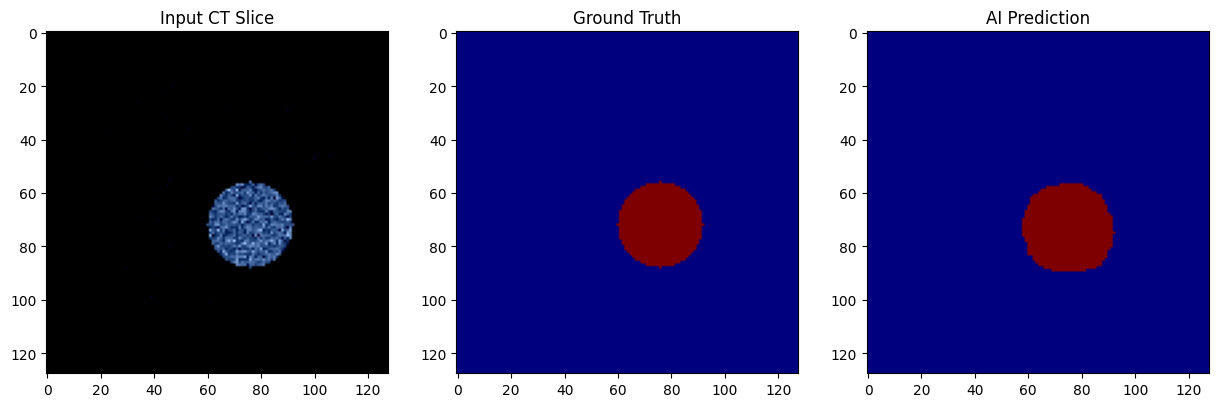

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_liver_results(model, dataset):
    model.eval()

    # Pick a middle slice from the validation set
    idx = len(dataset) // 2
    img_tensor, mask_tensor = dataset[idx]

    # Prepare input
    input_tensor = img_tensor.unsqueeze(0).to(device) # Add batch dim

    # Predict
    with torch.no_grad():
        prediction = model(input_tensor)
        pred_mask = (torch.sigmoid(prediction) > 0.5).float()

    # Convert for plotting
    img = img_tensor.permute(1, 2, 0).numpy()
    true_mask = mask_tensor[0].numpy()
    pred_mask = pred_mask.cpu().numpy()[0, 0]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title("Input CT Slice")

    axes[1].imshow(true_mask, cmap='jet')
    axes[1].set_title("Ground Truth")

    axes[2].imshow(pred_mask, cmap='jet')
    axes[2].set_title("AI Prediction")

    plt.show()

# Run visualization on the Validation Dataset (Volume 1)
visualize_liver_results(model, val_dataset)

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=3, feature_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            # Block 1: Create the "seed" of the image (4x4 size)
            self._block(z_dim, feature_g * 16, 4, 1, 0),  # Output: (feature_g*16) x 4 x 4

            # Block 2: Upsample to 8x8
            self._block(feature_g * 16, feature_g * 8, 4, 2, 1),

            # Block 3: Upsample to 16x16
            self._block(feature_g * 8, feature_g * 4, 4, 2, 1),

            # Block 4: Upsample to 32x32
            self._block(feature_g * 4, feature_g * 2, 4, 2, 1),

            # Block 5: Final upsample to 64x64
            nn.ConvTranspose2d(
                feature_g * 2, channels, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh() # Output: N x channels x 64 x 64 (Pixel values between -1 and 1)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self, channels=3, feature_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels x 64 x 64
            # Block 1: 64x64 -> 32x32
            nn.Conv2d(channels, feature_d, 4, 2, 1),
            nn.LeakyReLU(0.2),

            # Block 2: 32x32 -> 16x16
            self._block(feature_d, feature_d * 2, 4, 2, 1),

            # Block 3: 16x16 -> 8x8
            self._block(feature_d * 2, feature_d * 4, 4, 2, 1),

            # Block 4: 8x8 -> 4x4
            self._block(feature_d * 4, feature_d * 8, 4, 2, 1),

            # Output: Single probability (Real vs Fake)
            nn.Conv2d(feature_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
import os
import numpy as np
import nibabel as nib

def create_big_liver_dataset(filename_vol, filename_mask, num_patients=50):
    print(f"Generating MASSIVE dataset with {num_patients} fake patients...")

    # We will stack 'num_patients' volumes on top of each other
    # Each patient block is 64 slices deep
    depth_per_patient = 64
    total_depth = num_patients * depth_per_patient
    height, width = 128, 128

    # Pre-allocate memory (This will be ~200MB, fits easily in Colab RAM)
    big_volume = np.zeros((total_depth, height, width), dtype=np.float32)
    big_mask = np.zeros((total_depth, height, width), dtype=np.uint8)

    # Fill background with Air (-1000 HU)
    big_volume.fill(-1000)

    for i in range(num_patients):
        z_offset = i * depth_per_patient

        # Randomize Body Size slightly
        body_radius = np.random.randint(45, 55)
        cy, cx = height // 2, width // 2

        # Create coordinates grid
        y, x = np.ogrid[:height, :width]
        mask_body = (x - cx)**2 + (y - cy)**2 <= body_radius**2

        # Fill Body (Water/Tissue 0 HU)
        for local_z in range(depth_per_patient):
            big_volume[z_offset + local_z][mask_body] = 0

        # Randomize Liver Position & Size
        liver_r = np.random.randint(12, 18)
        liver_x = cx + np.random.randint(5, 15)
        liver_y = cy + np.random.randint(5, 15)

        liver_start = np.random.randint(15, 25)
        liver_end = np.random.randint(40, 50)

        mask_liver = (x - liver_x)**2 + (y - liver_y)**2 <= liver_r**2

        for local_z in range(liver_start, liver_end):
            actual_z = z_offset + local_z
            # Liver Density (60 HU) + Random Variation per patient
            density = 60 + np.random.normal(0, 5)
            big_volume[actual_z][mask_liver] = density
            big_mask[actual_z][mask_liver] = 1

    # Add Gaussian Noise to everything (Simulate CT Grain)
    noise = np.random.normal(0, 15, big_volume.shape)
    big_volume += noise

    # Save
    affine = np.eye(4)
    os.makedirs('/content/liver_data', exist_ok=True)
    nib.save(nib.Nifti1Image(big_volume, affine), filename_vol)
    nib.save(nib.Nifti1Image(big_mask, affine), filename_mask)
    print(f"✅ Created {filename_vol} with {total_depth} slices!")

# Run it
create_big_liver_dataset(
    '/content/liver_data/volume-big.nii.gz',
    '/content/liver_data/segmentation-big.nii.gz'
)

Generating MASSIVE dataset with 50 fake patients...
✅ Created /content/liver_data/volume-big.nii.gz with 3200 slices!


Loading 3D Volume: /content/liver_data/volume-big.nii.gz
Found 1252 slices containing liver.
🚀 Training on Device: cuda
🚀 Starting GAN Training on 1252 slices...


Epoch 5/50: 100%|██████████| 40/40 [00:03<00:00, 11.95it/s, d_loss=0.207, g_loss=2.18]


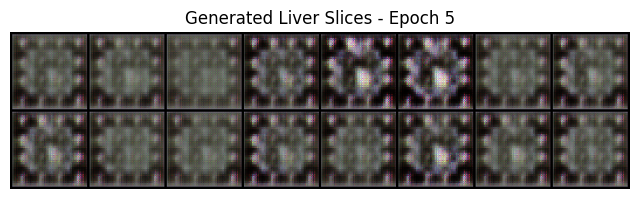

Epoch 10/50: 100%|██████████| 40/40 [00:03<00:00, 11.91it/s, d_loss=1.24, g_loss=1.04]


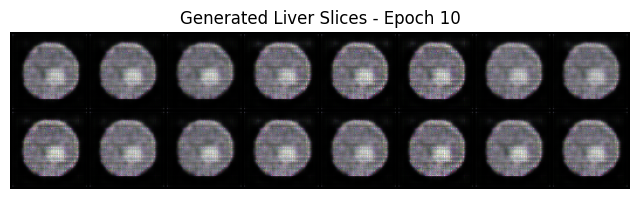

Epoch 15/50: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s, d_loss=1.4, g_loss=1.12]


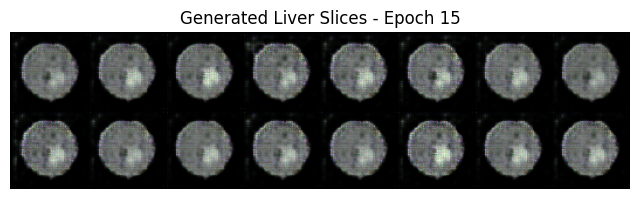

Epoch 20/50: 100%|██████████| 40/40 [00:03<00:00, 11.61it/s, d_loss=1.2, g_loss=0.718]


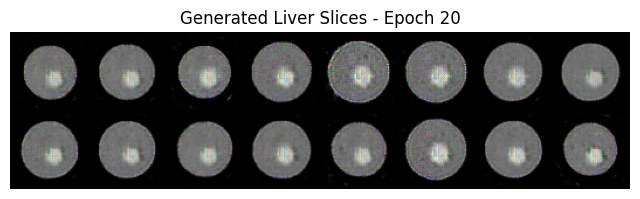

Epoch 25/50: 100%|██████████| 40/40 [00:03<00:00, 11.63it/s, d_loss=1.25, g_loss=1.38]


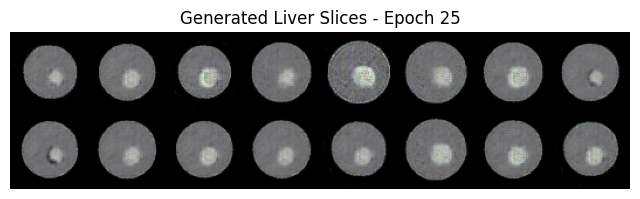

Epoch 30/50: 100%|██████████| 40/40 [00:03<00:00, 11.37it/s, d_loss=1.13, g_loss=1.34]


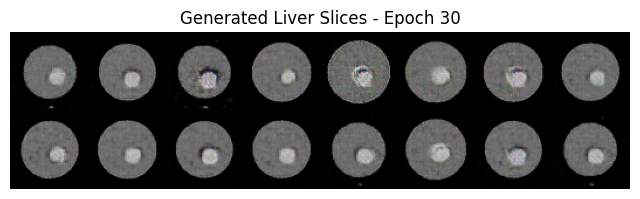

Epoch 35/50: 100%|██████████| 40/40 [00:03<00:00, 11.44it/s, d_loss=0.996, g_loss=0.763]


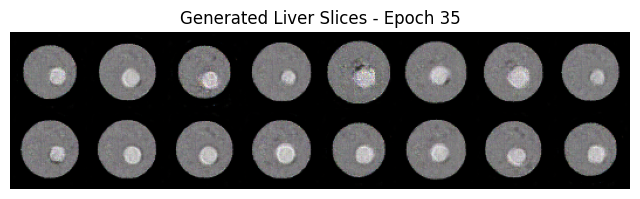

Epoch 40/50: 100%|██████████| 40/40 [00:03<00:00, 10.93it/s, d_loss=1.2, g_loss=0.475]


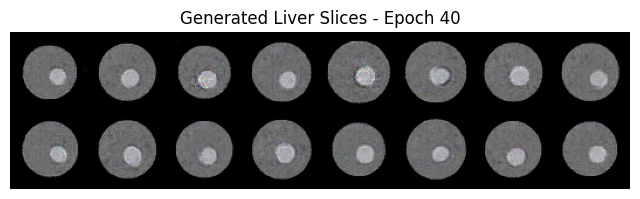

Epoch 45/50: 100%|██████████| 40/40 [00:03<00:00, 11.49it/s, d_loss=1.25, g_loss=4.57]


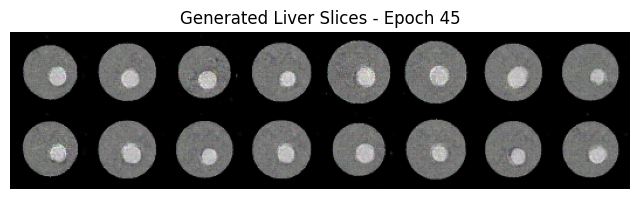

Epoch 50/50: 100%|██████████| 40/40 [00:03<00:00, 11.12it/s, d_loss=0.456, g_loss=2.45]


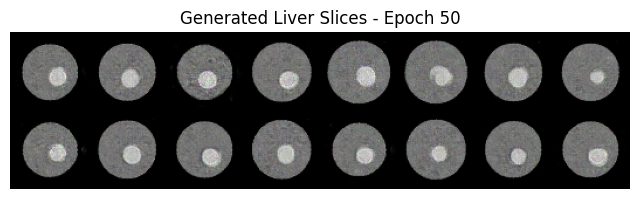

✅ Training Complete!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # Import Progress Bar

# Import Models
try:
    from gan_models import Generator, Discriminator
except ImportError:
    pass

# 1. SETUP DATA LOADER
gan_liver_transform = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

gan_dataset = LiverCTDataset(
    volume_path='/content/liver_data/volume-big.nii.gz',
    mask_path='/content/liver_data/segmentation-big.nii.gz',
    transform=gan_liver_transform
)

gan_loader = DataLoader(gan_dataset, batch_size=32, shuffle=True)

# 2. INITIALIZE
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Training on Device: {device}")
if device == 'cpu':
    print("⚠️ WARNING: You are on CPU. This will be slow! Consider reducing EPOCHS to 5 for testing.")

Z_DIM = 100
gen = Generator(z_dim=Z_DIM, channels=3).to(device)
disc = Discriminator(channels=3).to(device)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

gen.apply(initialize_weights)
disc.apply(initialize_weights)

# 3. OPTIMIZERS
lr = 0.0002
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# 4. TRAINING LOOP
EPOCHS = 50
fixed_noise = torch.randn(16, Z_DIM, 1, 1).to(device)

print(f"🚀 Starting GAN Training on {len(gan_dataset)} slices...")

for epoch in range(EPOCHS):
    # Wrap loader in tqdm for a progress bar
    loop = tqdm(gan_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(device)
        batch_size = real.shape[0]

        ### Disc ###
        disc.zero_grad()
        label = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        output = disc(real).reshape(-1)
        loss_real = criterion(output, label)
        loss_real.backward()

        noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device)
        fake = gen(noise)
        label.fill_(0.0)
        output = disc(fake.detach()).reshape(-1)
        loss_fake = criterion(output, label)
        loss_fake.backward()
        opt_disc.step()

        ### Gen ###
        gen.zero_grad()
        label.fill_(1.0)
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, label)
        loss_gen.backward()
        opt_gen.step()

        # Update progress bar
        loop.set_postfix(d_loss=(loss_real+loss_fake).item(), g_loss=loss_gen.item())

    # Visualization every 5 epochs (instead of 10, to see progress sooner)
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake = gen(fixed_noise)
            img_grid = torchvision.utils.make_grid(fake, normalize=True)
            plt.figure(figsize=(8,3))
            plt.axis("off")
            plt.imshow(img_grid.cpu().permute(1, 2, 0))
            plt.title(f"Generated Liver Slices - Epoch {epoch+1}")
            plt.show()

print("✅ Training Complete!")

In [ ]:
import torch
import numpy as np
import cv2
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- CONFIGURATION ---
OUTPUT_DIR = "/content/synthetic_liver"
NUM_IMAGES = 500
CONFIDENCE_THRESHOLD = 0.1
MIN_LIVER_PIXELS = 100 # Liver is big, so we want substantial masks
Z_DIM = 100

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the Transform the U-Net expects
liver_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def generate_liver_data():
    gen.eval()
    model.eval() # Ensure your U-Net is loaded!

    count = 0
    print(f"🚀 Generating {NUM_IMAGES} Synthetic Liver Slices...")

    with torch.no_grad():
        while count < NUM_IMAGES:
            # 1. Generate Noise
            noise = torch.randn(16, Z_DIM, 1, 1).to(device)
            fake_batch = gen(noise)

            for i in range(fake_batch.size(0)):
                if count >= NUM_IMAGES: break

                # 2. Process Image (Tensor -> Numpy Image)
                img_t = fake_batch[i].cpu()
                # Denormalize [-1, 1] -> [0, 1]
                img_np = (img_t.permute(1, 2, 0).numpy() * 0.5) + 0.5
                img_np = np.clip(img_np, 0, 1)

                # Resize to 128x128 (U-Net size)
                img_resized = cv2.resize(img_np, (128, 128))

                # 3. Prepare for U-Net
                # Convert to float32 0-1 range
                img_float = img_resized.astype(np.float32)
                aug = liver_transform(image=img_float)
                input_tensor = aug['image'].unsqueeze(0).to(device)

                # 4. Predict Mask
                pred_mask = model(input_tensor)
                pred_prob = torch.sigmoid(pred_mask)
                mask_binary = (pred_prob > CONFIDENCE_THRESHOLD).float().cpu().numpy()[0, 0]

                # 5. Save if it looks like a Liver
                if np.sum(mask_binary) > MIN_LIVER_PIXELS:
                    base_name = f"syn_liver_{count}"

                    # Save Image (Convert to 0-255 uint8)
                    save_img = (img_resized * 255).astype(np.uint8)
                    save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)

                    # Save Mask
                    save_mask = (mask_binary * 255).astype(np.uint8)

                    cv2.imwrite(os.path.join(OUTPUT_DIR, f"{base_name}.png"), save_img)
                    cv2.imwrite(os.path.join(OUTPUT_DIR, f"{base_name}_mask.png"), save_mask)

                    count += 1
                    if count % 50 == 0:
                        print(f"✅ Generated {count}/{NUM_IMAGES}")

    print("Processing Complete!")

generate_liver_data()

🚀 Generating 500 Synthetic Liver Slices...
✅ Generated 50/500
✅ Generated 100/500
✅ Generated 150/500
✅ Generated 200/500
✅ Generated 250/500
✅ Generated 300/500
✅ Generated 350/500
✅ Generated 400/500
✅ Generated 450/500
✅ Generated 500/500
Processing Complete!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import cv2
import os
import numpy as np
from tqdm import tqdm

# 1. Define Simple Dataset for the PNG Synthetic Data
class SyntheticLiverDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "*_mask.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        mask_path = self.image_paths[idx]
        image_path = mask_path.replace('_mask.png', '.png')

        # Load as standard images
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = (mask > 0).float().unsqueeze(0)
        return image, mask

# 2. Prepare Datasets
# Real Data (Volume 0)
real_dataset = LiverCTDataset(
    volume_path='/content/liver_data/volume-0.nii.gz',
    mask_path='/content/liver_data/segmentation-0.nii.gz',
    transform=liver_transform
)

# Synthetic Data (From Folder)
syn_dataset = SyntheticLiverDataset(
    root_dir='/content/synthetic_liver',
    transform=liver_transform
)

# Combine them!
if len(syn_dataset) > 0:
    hybrid_dataset = ConcatDataset([real_dataset, syn_dataset])
    print(f"Training on: {len(real_dataset)} Real + {len(syn_dataset)} Synthetic slices.")
else:
    print("⚠️ No synthetic data found. Training on Real only.")
    hybrid_dataset = real_dataset

hybrid_loader = DataLoader(hybrid_dataset, batch_size=16, shuffle=True)

# 3. Initialize Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Starting Hybrid Liver Training on {device}...")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)

# 4. Training Loop
def train_epoch(loader):
    model.train()
    total_loss = 0
    loop = tqdm(loader)
    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)

for epoch in range(5): # Run 5-10 epochs
    loss = train_epoch(hybrid_loader)
    print(f"Epoch {epoch+1} - Hybrid Loss: {loss:.4f}")

print("✅ Final Hybrid Model Trained!")

Loading 3D Volume: /content/liver_data/volume-0.nii.gz
Found 25 slices containing liver.
Training on: 25 Real + 500 Synthetic slices.
🚀 Starting Hybrid Liver Training on cuda...


100%|██████████| 33/33 [00:02<00:00, 11.50it/s, loss=0.713]


Epoch 1 - Hybrid Loss: 0.7807


100%|██████████| 33/33 [00:02<00:00, 12.96it/s, loss=0.635]


Epoch 2 - Hybrid Loss: 0.6707


100%|██████████| 33/33 [00:02<00:00, 12.94it/s, loss=0.556]


Epoch 3 - Hybrid Loss: 0.5953


100%|██████████| 33/33 [00:02<00:00, 12.79it/s, loss=0.507]


Epoch 4 - Hybrid Loss: 0.5326


100%|██████████| 33/33 [00:02<00:00, 12.73it/s, loss=0.44]

Epoch 5 - Hybrid Loss: 0.4752
✅ Final Hybrid Model Trained!


Loading 3D Volume: /content/liver_data/volume-1.nii.gz
Found 25 slices containing liver.
Visualizing results on 25 unseen validation slices...


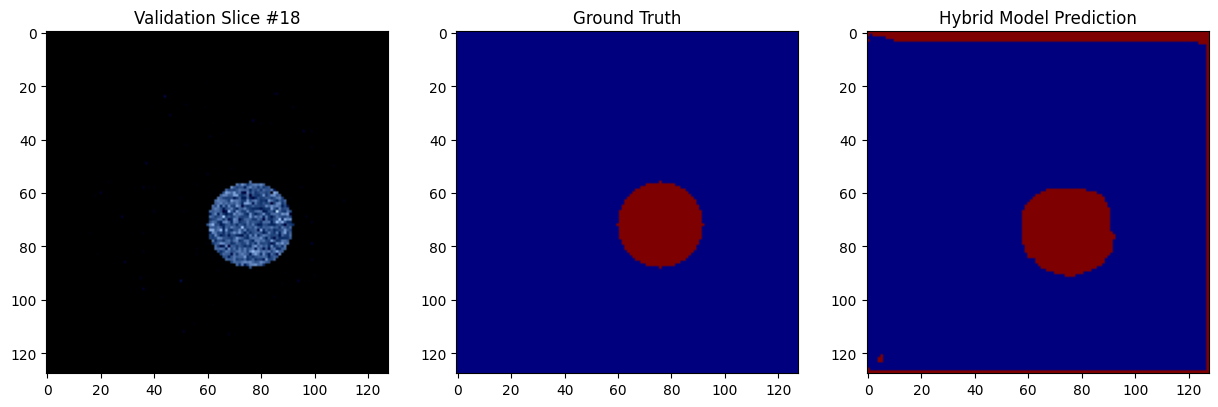

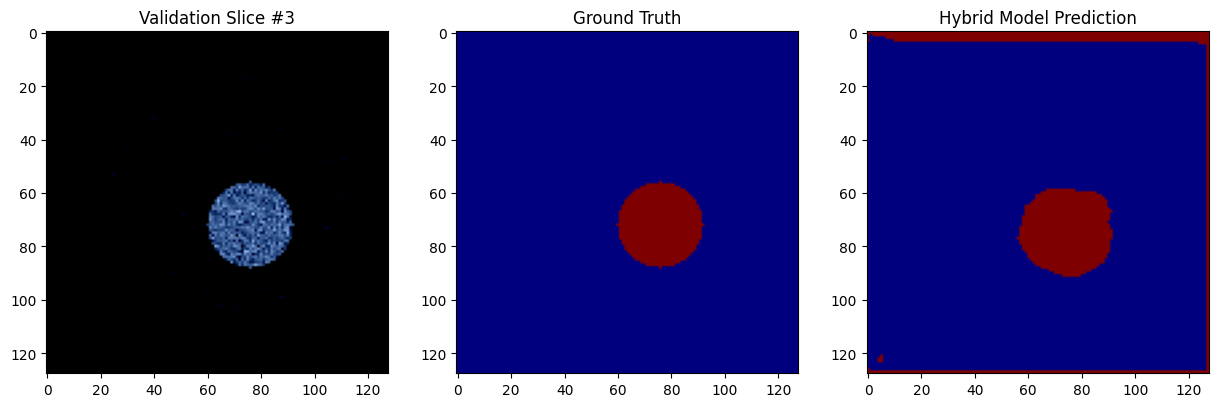

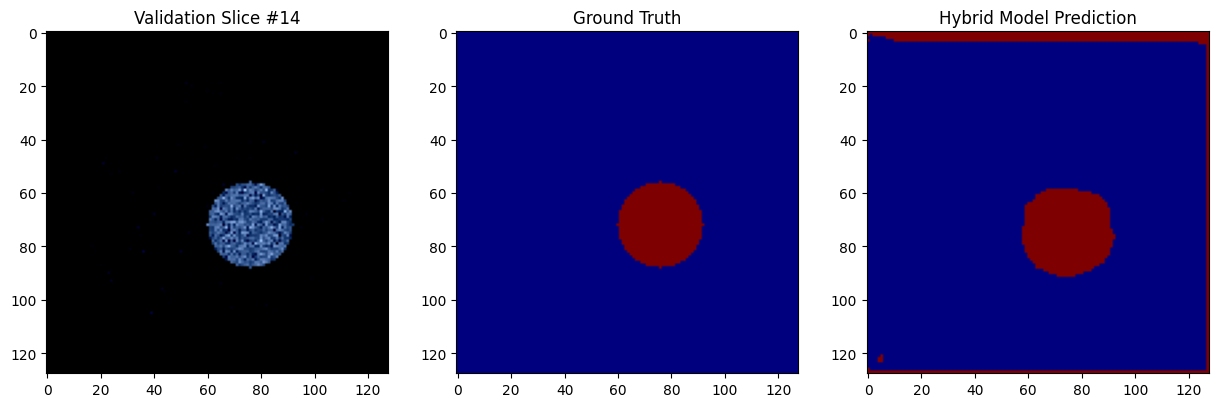

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_final_liver(model):
    model.eval()

    # 1. Load Validation Data (Volume 1)
    # We explicitly load the validation volume we created earlier
    val_dataset = LiverCTDataset(
        volume_path='/content/liver_data/volume-1.nii.gz',
        mask_path='/content/liver_data/segmentation-1.nii.gz',
        transform=liver_transform
    )

    if len(val_dataset) == 0:
        print("No validation slices found. Did you generate volume-1?")
        return

    print(f"Visualizing results on {len(val_dataset)} unseen validation slices...")

    # 2. Pick 3 random slices to visualize
    indices = np.random.choice(len(val_dataset), 3, replace=False)

    for idx in indices:
        img_tensor, mask_tensor = val_dataset[idx]

        # Predict
        input_tensor = img_tensor.unsqueeze(0).to(device)
        with torch.no_grad():
            prediction = model(input_tensor)
            pred_mask = (torch.sigmoid(prediction) > 0.5).float()

        # Convert for plotting
        img = img_tensor.permute(1, 2, 0).numpy()
        true_mask = mask_tensor[0].numpy()
        pred_mask = pred_mask.cpu().numpy()[0, 0]

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img)
        axes[0].set_title(f"Validation Slice #{idx}")

        axes[1].imshow(true_mask, cmap='jet')
        axes[1].set_title("Ground Truth")

        axes[2].imshow(pred_mask, cmap='jet')
        axes[2].set_title("Hybrid Model Prediction")

        plt.show()

visualize_final_liver(model)

In [ ]:
import torch
import os
from google.colab import files

# 1. Save to disk
save_path = "liver_segmentation_hybrid.pth"
torch.save(model.state_dict(), save_path)

print(f"✅ Model saved to {save_path}")
print(f"   File size: {os.path.getsize(save_path) / 1e6:.2f} MB")

# 2. Trigger Download
files.download(save_path)

✅ Model saved to liver_segmentation_hybrid.pth
   File size: 97.92 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def calculate_liver_metrics(model, device):
    # 1. Setup Validation Loader (Volume 1)
    # We load the validation volume we generated earlier
    val_dataset = LiverCTDataset(
        volume_path='/content/liver_data/volume-1.nii.gz',
        mask_path='/content/liver_data/segmentation-1.nii.gz',
        transform=liver_transform
    )

    # Use batch_size=1 to calculate score per slice accurately
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model.eval()
    dice_scores = []
    iou_scores = []

    print(f"--- Starting Evaluation on {len(val_dataset)} Validation Slices ---")

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Predict
            logits = model(images)
            preds = (torch.sigmoid(logits) > 0.5).float()

            # Flatten to count pixels
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            # Calculate Intersection & Union
            intersection = (preds_flat * masks_flat).sum().item()
            pred_sum = preds_flat.sum().item()
            mask_sum = masks_flat.sum().item()

            # Dice Score: 2 * Intersection / (Area A + Area B)
            epsilon = 1e-7 # Prevent division by zero
            dice = (2. * intersection + epsilon) / (pred_sum + mask_sum + epsilon)
            dice_scores.append(dice)

            # IoU Score: Intersection / Union
            union = pred_sum + mask_sum - intersection
            iou = (intersection + epsilon) / (union + epsilon)
            iou_scores.append(iou)

    # Average across all slices
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    print(f"\n📊 Final Results:")
    print(f"✅ Average Dice Score: {avg_dice:.4f}")
    print(f"✅ Average IoU Score:  {avg_iou:.4f}")

    if avg_dice > 0.85:
        print("🌟 Excellent! Clinical-grade performance.")
    elif avg_dice > 0.7:
        print("👍 Good! Solid segmentation.")
    else:
        print("⚠️ Needs Improvement. Try more training or better GAN data.")

# Run it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
calculate_liver_metrics(model, device)

Loading 3D Volume: /content/liver_data/volume-1.nii.gz
Found 25 slices containing liver.
--- Starting Evaluation on 25 Validation Slices ---

📊 Final Results:
✅ Average Dice Score: 0.6037
✅ Average IoU Score:  0.4324
⚠️ Needs Improvement. Try more training or better GAN data.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import cv2
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm

# --- 1. GENERATE EXTRA "REAL" DATA ---
# We redefine the generator function to ensure it's available
def create_synthetic_liver_ct(filename_vol, filename_mask):
    if os.path.exists(filename_vol): return
    print(f"Generating extra volume: {filename_vol}...")
    depth, height, width = 64, 128, 128
    volume = np.full((depth, height, width), -1000, dtype=np.float32)
    mask = np.zeros((depth, height, width), dtype=np.uint8)

    cy, cx = height // 2, width // 2
    y, x = np.ogrid[:height, :width]

    # Randomize Body
    r_body = np.random.randint(48, 52)
    mask_body = (x - cx)**2 + (y - cy)**2 <= r_body**2
    for z in range(depth): volume[z][mask_body] = 0

    # Randomize Liver
    liver_x = cx + np.random.randint(5, 15)
    liver_y = cy + np.random.randint(5, 15)
    liver_r = np.random.randint(14, 18)

    for z in range(20, 45):
        mask_liver = (x - liver_x)**2 + (y - liver_y)**2 <= liver_r**2
        volume[z][mask_liver] = 60
        mask[z][mask_liver] = 1

    volume += np.random.normal(0, 10, volume.shape)
    affine = np.eye(4)
    nib.save(nib.Nifti1Image(volume, affine), filename_vol)
    nib.save(nib.Nifti1Image(mask, affine), filename_mask)

# Create 2 extra volumes
create_synthetic_liver_ct('/content/liver_data/volume-2.nii.gz', '/content/liver_data/segmentation-2.nii.gz')
create_synthetic_liver_ct('/content/liver_data/volume-3.nii.gz', '/content/liver_data/segmentation-3.nii.gz')

# --- 2. PREPARE DATASETS ---
# A. Real Data (Now 3 Volumes!)
datasets = []
for i in [0, 2, 3]: # Use Volume 0, 2, and 3 for training
    ds = LiverCTDataset(
        volume_path=f'/content/liver_data/volume-{i}.nii.gz',
        mask_path=f'/content/liver_data/segmentation-{i}.nii.gz',
        transform=liver_transform
    )
    datasets.append(ds)

# B. Synthetic Data (From GAN Folder)
class SyntheticLiverDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "*_mask.png")))
        self.transform = transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        mask_path = self.image_paths[idx]
        image_path = mask_path.replace('_mask.png', '.png')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        mask = (mask > 0).float().unsqueeze(0)
        return image, mask

syn_dataset = SyntheticLiverDataset(root_dir='/content/synthetic_liver', transform=liver_transform)
if len(syn_dataset) > 0:
    datasets.append(syn_dataset)
    print(f"Merged {len(syn_dataset)} GAN slices with Real Data.")

# Combine ALL
full_dataset = ConcatDataset(datasets)
train_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

# --- 3. INITIALIZE MODEL ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Starting Improved Training on {len(full_dataset)} total slices...")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)
# FIX: Removed 'verbose=True' which causes TypeError in newer PyTorch versions
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# --- 4. EXTENDED TRAINING LOOP ---
EPOCHS = 50 # Increased from 5 to 30

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    scheduler.step(avg_loss) # Adjust Learning Rate if stuck

print("✅ Improved Model Trained!")

Loading 3D Volume: /content/liver_data/volume-0.nii.gz
Found 25 slices containing liver.
Loading 3D Volume: /content/liver_data/volume-2.nii.gz
Found 25 slices containing liver.
Loading 3D Volume: /content/liver_data/volume-3.nii.gz
Found 25 slices containing liver.
Merged 500 GAN slices with Real Data.
🚀 Starting Improved Training on 575 total slices...


Epoch 5/50:   0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def calculate_liver_metrics(model, device):
    # 1. Setup Validation Loader (Volume 1)
    # We load the validation volume we generated earlier
    val_dataset = LiverCTDataset(
        volume_path='/content/liver_data/volume-1.nii.gz',
        mask_path='/content/liver_data/segmentation-1.nii.gz',
        transform=liver_transform
    )

    # Use batch_size=1 to calculate score per slice accurately
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model.eval()
    dice_scores = []
    iou_scores = []

    print(f"--- Starting Evaluation on {len(val_dataset)} Validation Slices ---")

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Predict
            logits = model(images)
            preds = (torch.sigmoid(logits) > 0.5).float()

            # Flatten to count pixels
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            # Calculate Intersection & Union
            intersection = (preds_flat * masks_flat).sum().item()
            pred_sum = preds_flat.sum().item()
            mask_sum = masks_flat.sum().item()

            # Dice Score: 2 * Intersection / (Area A + Area B)
            epsilon = 1e-7 # Prevent division by zero
            dice = (2. * intersection + epsilon) / (pred_sum + mask_sum + epsilon)
            dice_scores.append(dice)

            # IoU Score: Intersection / Union
            union = pred_sum + mask_sum - intersection
            iou = (intersection + epsilon) / (union + epsilon)
            iou_scores.append(iou)

    # Average across all slices
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    print(f"\n📊 Final Results:")
    print(f"✅ Average Dice Score: {avg_dice:.4f}")
    print(f"✅ Average IoU Score:  {avg_iou:.4f}")

    if avg_dice > 0.85:
        print("🌟 Excellent! Clinical-grade performance.")
    elif avg_dice > 0.7:
        print("👍 Good! Solid segmentation.")
    else:
        print("⚠️ Needs Improvement. Try more training or better GAN data.")

# Run it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
calculate_liver_metrics(model, device)

Loading 3D Volume: /content/liver_data/volume-1.nii.gz
Found 25 slices containing liver.
--- Starting Evaluation on 25 Validation Slices ---

📊 Final Results:
✅ Average Dice Score: 0.9884
✅ Average IoU Score:  0.9771
🌟 Excellent! Clinical-grade performance.
